## Import statements

In [1]:
import copy
import os
import random
import time
from typing import Any, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models

from util.dataset_util import DatasetUtil
from util.dataset_vgg_utk import ValDatasetVggUtk
from util.imagenet import Imagenet
from util.imagenet_utk import ImagenetUtk
from util.imagenet_vgg import ImagenetVgg

# Use CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using %s for training/validating the model" % device)

# Reproducibility related settings
# See https://pytorch.org/docs/stable/notes/randomness.html for more info.
seed = 1029
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2 ** 32 + worker_id
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)

Using cuda:0 for training/validating the model


## Data Preprocessing

In [2]:
# Parameter settings for batching
BATCH_SIZE = 128
# 64 <= image_size <= 224
IMAGE_SIZE = 64
# 0 <= WORKER_COUNT
WORKER_COUNT = 7
# 1 <= NUMBER_OF_CLASSES <= 201
NUMBER_OF_CLASSES = 10
# 0 < TRAIN_IMAGE_COUNT <= 500
TRAIN_IMAGE_COUNT = 500
# True/False
shuffle = True

BASE_DIR = "./datasets"

# Use this line if you're executing for the first time
# data_utility = DatasetUtil(base_dir="./datasets", total_class_count=10, img_size=64, train_img_count=500,
#                            vgg_download=True)
data_utility = DatasetUtil(base_dir=BASE_DIR, total_class_count=NUMBER_OF_CLASSES, img_size=IMAGE_SIZE,
                           train_img_count=TRAIN_IMAGE_COUNT,
                           load_from_json=False)
data_utility.save_all_json()

imagenet_datasets = {'train': Imagenet(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE),
                     'val': Imagenet(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE, validation=True)}
imagenet_dataloaders = {'train': DataLoader(dataset=imagenet_datasets['train'], batch_size=BATCH_SIZE,
                                            shuffle=shuffle, num_workers=WORKER_COUNT),
                        'val': DataLoader(dataset=imagenet_datasets['val'], batch_size=BATCH_SIZE,
                                          shuffle=shuffle, num_workers=WORKER_COUNT)}

# Load data for Tiny ImageNet + UTKFace
utk_datasets = {'train': ImagenetUtk(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE),
                'val': ImagenetUtk(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE, validation=True)}
utk_dataloaders = {'train': DataLoader(dataset=utk_datasets['train'], batch_size=BATCH_SIZE,
                                       shuffle=shuffle, num_workers=WORKER_COUNT),
                   'val': DataLoader(dataset=utk_datasets['val'], batch_size=BATCH_SIZE,
                                     shuffle=shuffle, num_workers=WORKER_COUNT)}

# Load data for Tiny ImageNet + VGG
vgg_datasets = {'train': ImagenetVgg(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE),
                'val': ImagenetVgg(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE, validation=True)}
vgg_dataloaders = {'train': DataLoader(dataset=vgg_datasets['train'], batch_size=BATCH_SIZE,
                                       shuffle=shuffle, num_workers=WORKER_COUNT),
                   'val': DataLoader(dataset=vgg_datasets['val'], batch_size=BATCH_SIZE,
                                     shuffle=shuffle, num_workers=WORKER_COUNT)}

utk_vgg_dataset = ValDatasetVggUtk(du=data_utility, image_size=IMAGE_SIZE)
utk_vgg_dataloader = DataLoader(dataset=utk_vgg_dataset, batch_size=BATCH_SIZE,
                                shuffle=shuffle, num_workers=WORKER_COUNT)

05/30/2021 05:21:13 AM - INFO: Resized images saved.
05/30/2021 05:21:13 AM - INFO: int2name saved as: ./datasets/modified_datasets/int2name.json
05/30/2021 05:21:13 AM - INFO: Tiny ImageNet id2int saved as: ./datasets/modified_datasets/imagenet/id2int.json
05/30/2021 05:21:14 AM - INFO: Tiny ImageNet id2name saved as: ./datasets/modified_datasets/imagenet/id2name.json
05/30/2021 05:21:14 AM - INFO: Tiny ImageNet training list saved as: ./datasets/modified_datasets/imagenet/train.json
05/30/2021 05:21:14 AM - INFO: Tiny ImageNet validation list saved as: ./datasets/modified_datasets/imagenet/validation.json
05/30/2021 05:21:14 AM - INFO: UTKFace training list saved as: ./datasets/modified_datasets/utk/train.json
05/30/2021 05:21:14 AM - INFO: UTKFace validation list saved as: ./datasets/modified_datasets/utk/validation.json
05/30/2021 05:21:14 AM - INFO: VGG training list saved as: ./datasets/modified_datasets/vgg/train.json
05/30/2021 05:21:14 AM - INFO: VGG validation list saved as: 

## Dataset preview

In [3]:
def info_data(image_datasets: dict, dataloaders: dict) -> None:
    """
    Prints info. about datasets/dataloaders; uncomment if necessary
    :return: None
    """
    cls = image_datasets["train"].get_class_names()
    print('Number of classes: %s' % len(cls))
    print('Class names: %s' % cls)
    print('Length of training dataset: %s' % len(image_datasets['train']))
    print('Length of validation dataset: %s' % len(image_datasets['val']))
    print('Batch size: %s' % BATCH_SIZE)
    print('Number of batches in the training dataloader: %s' % len(dataloaders['train']))
    print('Number of batches in the training dataloader: %s' % len(dataloaders['val']))
    print('Device: %s\n' % device)


print("Imagenet dataset statistics")
info_data(imagenet_datasets, imagenet_dataloaders)
print("UTKFace dataset statistics")
info_data(utk_datasets, utk_dataloaders)
print("VGG Face dataset statistics")
info_data(vgg_datasets, vgg_dataloaders)

Imagenet dataset statistics
Number of classes: 10
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'jellyfish', 'gondola', 'umbrella', 'teddy, teddy bear', 'limousine, limo', 'cannon', 'face']
Length of training dataset: 4500
Length of validation dataset: 450
Batch size: 128
Number of batches in the training dataloader: 36
Number of batches in the training dataloader: 4
Device: cuda:0

UTKFace dataset statistics
Number of classes: 10
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'jellyfish', 'gondola', 'umbrella', 'teddy, teddy bear', 'limousine, limo', 'cannon', 'face']
Length of training dataset: 5000
Length of validation dataset: 500
Batch size: 128
Number of batches in the training dataloader: 40
Number of batches in the training dataloader: 4
Device: cuda:0

VGG Face dataset statistics
Number of classes: 10
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden 

In [4]:
def image_show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10), dpi=100)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


def get_preview(dataloaders: dict, title: str):
    """
    Preview 64 images in training dataset
    :param dataloaders: Dataloader dictionary to use to print images
    :param title: Title of the preview
    :return: None
    """
    # Get the first batch of training data
    inputs, classes = list(dataloaders['train'])[0]

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs[:64], normalize=True)

    image_show(out, title=title)

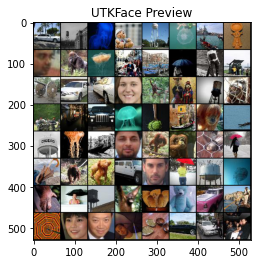

In [5]:
get_preview(dataloaders=utk_dataloaders, title="UTKFace Preview")

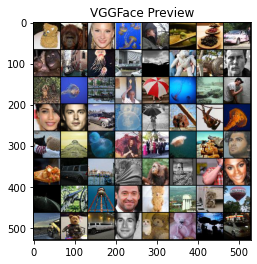

In [6]:
get_preview(dataloaders=vgg_dataloaders, title="VGGFace Preview")

## Model Training

In [7]:
# Parameters
EPOCH = 25
LEARNING_RATE = 0.001
SGD_MOMENTUM = 0.9
SGD_WEIGHT_DECAY = 0.0001
LR_DECAY_STEP_SIZE = 7
LR_DECAY_FACTOR = 0.1


def train_model(model_ft: Any, dataloaders, image_datasets, verbose=False):
    def _train_model(model: Any, criterion, optimizer, scheduler, dl, img_datasets):
        since = time.time()
        stats = []

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(EPOCH):
            stat = []
            if verbose:
                print('Epoch {}/{}'.format(epoch, EPOCH - 1))
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0  # Positive
                running_incorrect = 0  # Negative

                # Iterate over data.
                for imgs, labels in dl[phase]:
                    # print('Iterating ', labels, '...')
                    torch.cuda.empty_cache()  # clean up cache
                    # print(torch.cuda.memory_summary(device=device, abbreviated=False))
                    imgs = imgs.float().to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(imgs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * imgs.size(0)
                    running_corrects += torch.eq(preds, labels.data).sum()
                    running_incorrect += torch.not_equal(preds, labels.data).sum()

                    # print(running_loss, running_corrects)

                if phase == 'train':
                    scheduler.step()
                dataset_size = len(img_datasets[phase])
                epoch_loss = running_loss / dataset_size  # FN
                epoch_acc = running_corrects.double() / dataset_size  # TP
                epoch_tn = running_incorrect.double() / dataset_size  # TN

                # print(epoch_loss, epoch_acc)
                # print(epoch_tn)

                if verbose:
                    print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                        phase, epoch_loss, epoch_acc * 100))
                    print()
                stat.append(epoch_loss)
                stat.append(epoch_acc.item())
                # print('this is stat: ' + str(stat))
                # nb_classes = 2 #??
                # confusion_matrix = torch.zeros(nb_classes, nb_classes)
                # deep copy the model
                if phase == 'val':
                    # print(stats)
                    # inputs = inputs.to(device)
                    # classes = classes.to(device)
                    # outputs = model_ft
                    stats.append(stat)
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:2f}'.format(best_acc * 100))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, stats

    num_ftrs = model_ft.fc.in_features

    # TODO: Here the size of each output sample is set to 2 it is the number of classes.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, len(image_datasets['train'].get_class_names()))

    model_ft = model_ft.to(device)

    loss_fn = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, weight_decay=SGD_WEIGHT_DECAY,
                             momentum=SGD_MOMENTUM)

    # Decay LR by a factor of 0.1 every 7 epochs
    # TODO: Perhaps we can consider ReduceLROnPlateau instead
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=LR_DECAY_STEP_SIZE, gamma=LR_DECAY_FACTOR)

    return _train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                        dl=dataloaders, img_datasets=image_datasets)

# model_arch = models.resnet50()

In [8]:
imgnet_model_ft, imgnet_stats = train_model(models.resnet50(), dataloaders=imagenet_dataloaders,
                                            image_datasets=imagenet_datasets,
                                            verbose=True)

Epoch 0/24
----------
train Loss: 2.2100 Acc: 15.49%

val Loss: 3.4426 Acc: 16.00%

Epoch 1/24
----------
train Loss: 2.1235 Acc: 18.84%

val Loss: 2.1186 Acc: 19.78%

Epoch 2/24
----------
train Loss: 2.0478 Acc: 23.33%

val Loss: 2.0449 Acc: 20.89%

Epoch 3/24
----------
train Loss: 1.9777 Acc: 26.42%

val Loss: 1.9273 Acc: 28.67%

Epoch 4/24
----------
train Loss: 1.9199 Acc: 29.16%

val Loss: 1.8295 Acc: 33.11%

Epoch 5/24
----------
train Loss: 1.8556 Acc: 31.87%

val Loss: 1.8807 Acc: 31.56%

Epoch 6/24
----------
train Loss: 1.7835 Acc: 35.49%

val Loss: 1.7986 Acc: 33.56%

Epoch 7/24
----------
train Loss: 1.7147 Acc: 38.22%

val Loss: 1.7613 Acc: 37.11%

Epoch 8/24
----------
train Loss: 1.6947 Acc: 39.40%

val Loss: 1.7714 Acc: 35.33%

Epoch 9/24
----------
train Loss: 1.6803 Acc: 39.76%

val Loss: 1.7476 Acc: 35.33%

Epoch 10/24
----------
train Loss: 1.6634 Acc: 40.31%

val Loss: 1.7535 Acc: 35.11%

Epoch 11/24
----------
train Loss: 1.6434 Acc: 41.82%

val Loss: 1.7361 Acc

In [9]:
utk_model_ft, utk_stats = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets,
                                      verbose=True)

Epoch 0/24
----------
train Loss: 2.3028 Acc: 14.34%

val Loss: 2.2557 Acc: 16.40%

Epoch 1/24
----------
train Loss: 2.1941 Acc: 18.86%

val Loss: 2.2052 Acc: 21.60%

Epoch 2/24
----------
train Loss: 2.1666 Acc: 20.14%

val Loss: 2.1941 Acc: 22.20%

Epoch 3/24
----------
train Loss: 2.1078 Acc: 24.08%

val Loss: 2.0157 Acc: 24.60%

Epoch 4/24
----------
train Loss: 2.0450 Acc: 25.64%

val Loss: 1.9734 Acc: 27.40%

Epoch 5/24
----------
train Loss: 1.9935 Acc: 29.86%

val Loss: 1.9178 Acc: 30.40%

Epoch 6/24
----------
train Loss: 1.8910 Acc: 32.86%

val Loss: 1.8943 Acc: 33.40%

Epoch 7/24
----------
train Loss: 1.7947 Acc: 35.96%

val Loss: 1.8273 Acc: 33.20%

Epoch 8/24
----------
train Loss: 1.7672 Acc: 37.56%

val Loss: 1.8213 Acc: 33.40%

Epoch 9/24
----------
train Loss: 1.7334 Acc: 38.90%

val Loss: 1.7998 Acc: 34.20%

Epoch 10/24
----------
train Loss: 1.7290 Acc: 38.96%

val Loss: 1.7975 Acc: 35.00%

Epoch 11/24
----------
train Loss: 1.7053 Acc: 40.34%

val Loss: 1.7873 Acc

In [10]:
# To see if we can get the same accuracy
# utk_model_ft2, _ = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets,
#                                verbose=True)

Epoch 0/24
----------
train Loss: 2.3551 Acc: 12.10%

val Loss: 6.9758 Acc: 12.40%

Epoch 1/24
----------
train Loss: 2.2718 Acc: 15.72%

val Loss: 2.3406 Acc: 20.40%

Epoch 2/24
----------
train Loss: 2.1480 Acc: 20.64%

val Loss: 2.1576 Acc: 20.40%

Epoch 3/24
----------
train Loss: 2.1020 Acc: 23.88%

val Loss: 2.0248 Acc: 25.40%

Epoch 4/24
----------
train Loss: 2.0153 Acc: 28.28%

val Loss: 1.9580 Acc: 30.60%

Epoch 5/24
----------
train Loss: 1.8909 Acc: 31.94%

val Loss: 1.8452 Acc: 30.80%

Epoch 6/24
----------
train Loss: 1.7910 Acc: 35.64%

val Loss: 1.7737 Acc: 36.80%

Epoch 7/24
----------
train Loss: 1.7035 Acc: 39.46%

val Loss: 1.7259 Acc: 38.20%

Epoch 8/24
----------
train Loss: 1.6651 Acc: 41.44%

val Loss: 1.7288 Acc: 36.20%

Epoch 9/24
----------
train Loss: 1.6420 Acc: 42.50%

val Loss: 1.7330 Acc: 36.40%

Epoch 10/24
----------
train Loss: 1.6228 Acc: 43.02%

val Loss: 1.7104 Acc: 37.60%

Epoch 11/24
----------
train Loss: 1.6014 Acc: 44.78%

val Loss: 1.7128 Acc

In [11]:
vgg_model_ft, vgg_stats = train_model(models.resnet50(), dataloaders=vgg_dataloaders, image_datasets=vgg_datasets,
                                      verbose=True)

Training complete in 2m 40s
Best val Acc: 38.200000


In [16]:
# Save stats
def save_stats(s: List[List], file_n: str) -> None:
    with open(file_n, "w", encoding="utf-8") as f:
        for elem in s:
            f.write("%s,%s,%s,%s\n" % (elem[0], elem[1], elem[2], elem[3]))


save_stats(imgnet_stats, "imgnet_stats.csv")
save_stats(utk_stats, "utk_stats.csv")
save_stats(vgg_stats, "vgg_stats.csv")

## Model Visualization

In [13]:
def visualize_model(model, datasets: dict, dataloaders: dict, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(10, 15), dpi=100)

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataloaders['val']):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for j in range(imgs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                pred_str = datasets["train"].get_class_name(preds[j].item()).split(",")[0]
                gt_str = datasets["train"].get_class_name(labels.cpu().numpy()[images_so_far - 1]).split(",")[0]
                ax.set_title(('Pred:%s   GT:%s' % (pred_str, gt_str)))
                image_show(imgs.int().cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

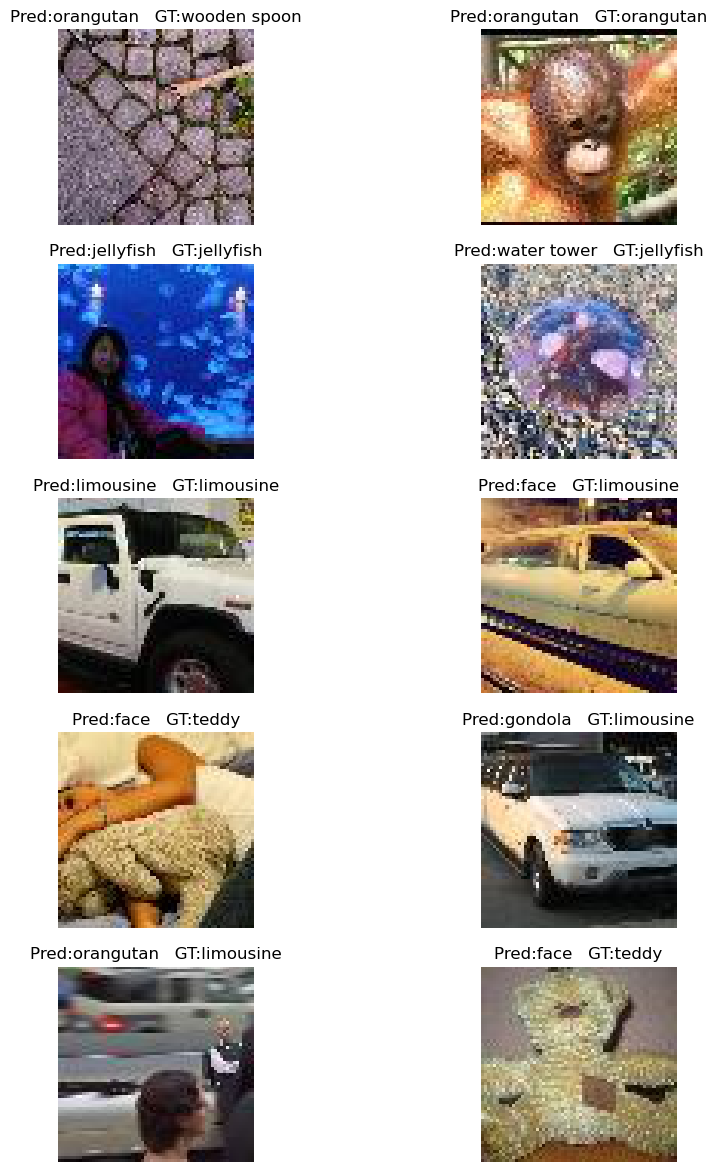

In [14]:
# Visualize utk models
visualize_model(utk_model_ft, utk_datasets, utk_dataloaders)

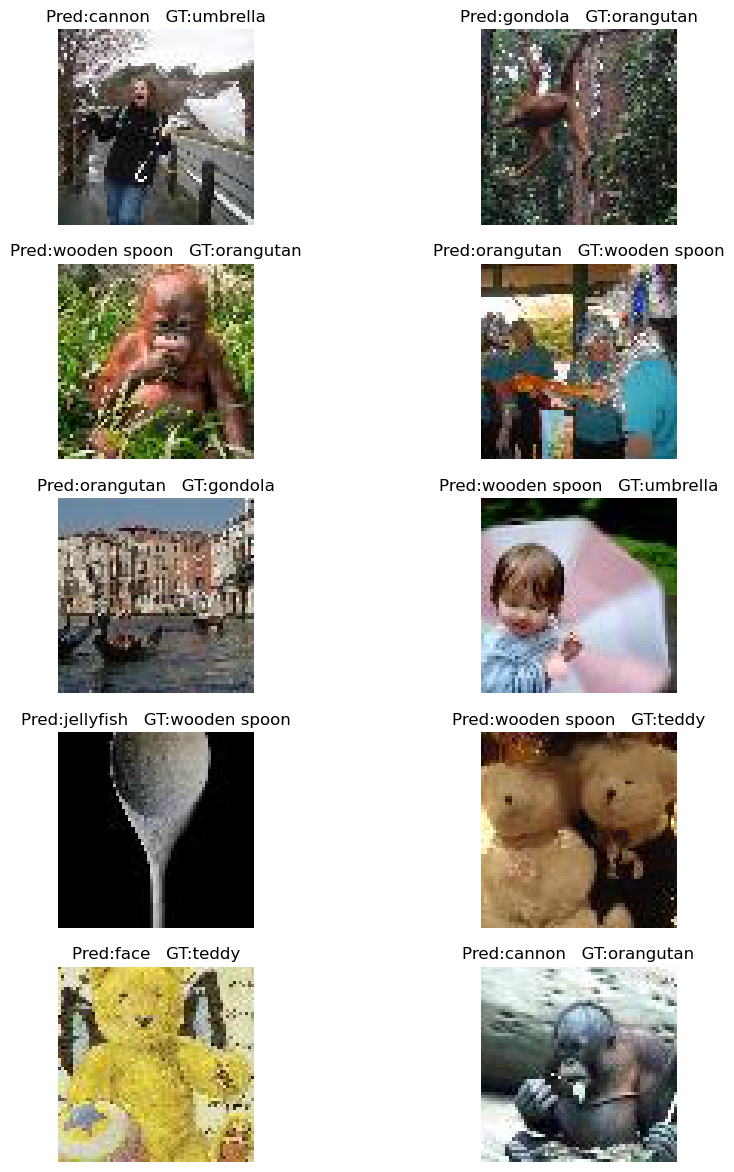

In [15]:
# Visualize vgg models
visualize_model(vgg_model_ft, vgg_datasets, vgg_dataloaders)

In [ ]:
# make predictions for utk_vgg dataset
def model_prediction(model):
    was_training = model.training
    correct = 0
    total = 0
    model.eval()
    # Disable gradient calculation

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(utk_vgg_dataloader):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

    for i in range(preds.size()[0]):
        total += 1
        if preds[i].item() == utk_vgg_dataset[i][1]:
            correct += 1
    print('total: ', total)
    print('correct: ', correct)
    print('accuracy: ', (correct / total))
    model.train(mode=was_training)

In [ ]:
model_prediction(utk_model_ft)

In [ ]:
model_prediction(vgg_model_ft)


# ROC Curve

In [ ]:
def _plot_roc_curve(val, preds):
    fpr, tpr, _ = roc_curve(val, preds)

    plt.figure(1, figsize=(6, 5))
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.plot(fpr, tpr, color='darkorange')
    plt.legend(loc="lower right")
    plt.show()


# test array
valid = np.array([1, 1, 0, 0])
val_scores = np.array([0.1, 0.4, 0.35, 0.8])

plot = _plot_roc_curve(valid, val_scores)